# Tutorial 3: Stereo-seq

In this tutorial, we demonstrate how to apply DeepST to Stereo-seq data for spatial domains identification. We take mouse embryo 9.5 data as example and set the number of clusters as 22. Mouse embryo Stereo-seq data were downloaded from https://db.cngb.org/stomics/mosta/ and provided at https://drive.google.com/drive/folders/1QWHFMzhQ7WorVNLwx88xT-rbojf4nh9T.

Before running the model, please download input data by the link above. 

In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp

In [2]:
from DeepST import DeepST

In [3]:
dataset = 'Mouse_Embryo'

In [4]:
# set random seed
random_seed = 50 
DeepST.fix_seed(random_seed)

In [5]:
# Run device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# the location of R, which is necessary for mclust algorithm. Please replace it with local R installation path
os.environ['R_HOME'] = '/scbio4/tools/R/R-4.0.3_openblas/R-4.0.3'

In [6]:
# the number of clusters
n_clusters = 22

In [7]:
# read data
file_path = './data/Mouse_Embryo/' #please replace it with the download path
adata = sc.read_h5ad(file_path + 'E9.5_E1S1.MOSTA.h5ad')
adata.var_names_make_unique()

In [8]:
# filter out genes expressed in less than 50 beads 
sc.pp.filter_genes(adata, min_cells=50)

# preprocessing for ST data
DeepST.preprocess(adata)

# build graph
from DeepST.preprocess import construct_interaction_KNN
construct_interaction_KNN(adata)
DeepST.add_contrastive_label(adata)

/home/yahui/anaconda3/envs/long/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


Graph constructed!


In [9]:
# get features
DeepST.get_feature(adata)

In [10]:
# define and run model
model = DeepST.Train(adata, datatype='Stereo', device=device)
adata.obsm['emb'] = model.train()

Building sparse matrix ...
Begin to train ST data...


100%|█████████████████████████████████████████| 600/600 [00:12<00:00, 49.11it/s]


Optimization finished for ST data!


In [12]:
# clustering
from DeepST.utils import clustering
clustering(adata, n_clusters, datatype='Slide', refinement=False)

fitting ...
  |======================================================================| 100%


Text(0.5, 1.0, 'Mouse Embryo E9.5')

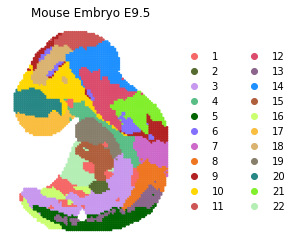

In [18]:
import matplotlib.pyplot as plt
#adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (3, 4)
plot_color=["#F56867","#556B2F","#C798EE","#59BE86","#006400","#8470FF",
            "#CD69C9","#EE7621","#B22222","#FFD700","#CD5555","#DB4C6C",
            "#8B658B","#1E90FF","#AF5F3C","#CAFF70", "#F9BD3F","#DAB370",
           "#877F6C","#268785", '#82EF2D', '#B4EEB4']

ax = sc.pl.embedding(adata, basis="spatial", 
                     color="label", 
                     s=30, 
                     show=False, 
                     palette=plot_color,
                     title='DeepST')
ax.axis('off')
ax.set_title('Mouse Embryo E9.5')